In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
def generate_ratings(nb_rows, nb_cols, min_nb_recomm=1, max_nb_recomm=2, min_rating =1, max_rating=5, seed = 0):
  '''Function to generate test rating matrices 
  nb_rows : nb of users
  nb_cols : nb of items
  min_nb_recomm : minimum number of recommendation for each user
  max_nb_recomm : max number of recommendation for each user
  min_rating : minimum rating possible 
  max_rating : maximum rating possible
  seed : np random seed for reproducibility '''
  np.random.seed(seed)
  ratings = np.zeros((nb_rows,nb_cols))

  for i in range(nb_rows):

    nb_recomm = np.random.randint(min_nb_recomm, max_nb_recomm+1)

    indexes = np.random.choice(np.arange(nb_cols), nb_recomm, replace = False)

    for index in indexes :
      ratings[i,index] = np.random.randint(min_rating, max_rating)
  return ratings.astype(int)

In [9]:
class recommender_system:
  '''Simple recommender system class based on matrix factorization'''

  def __init__(self, k, lr, lambda_reg):
    '''Instantiates recommendation_system class.
    k : rank dimension of factorized matrix
    lr : learning rate
    lambda_reg : regularization parameter
    max_value : maximum value possible for the generated matrices to avoid overflow'''
    self.k = k
    self.lr = lr
    self.lambda_reg = lambda_reg
    
  
  def set_k(self, k):
    '''Set rank of the two factorized matrices'''
    self.k = k
  
  def set_lr(self, lr):
    '''set learning rate '''
    self.lr = lr
  
  def set_lambda_reg(self,lambda_reg):
    '''set regularization parameter'''
    self.lambda_reg=lambda_reg

  def instantiate_matrices(self):
    '''Instantiate factorized matrixes'''
    self.first_mat = np.random.randn(self.nb_rows, self.k)
    self.second_mat = np.random.randn(self.nb_cols, self.k)

  def instantiate_initially_pressent_items(self):
    '''Creates a 2d list from Ratings. Each row i of this list contains the items that the user i has already rated'''
    self.tested_items = [[] for i in range(self.nb_rows)]
    for row, col, _ in self.Ratings:
      self.tested_items[row].append(col)

  def load_sparse_data(self,file_, delimiter = ",", nb_rows_to_keep = -1, nb_cols_to_keep =-1, shuffle_matrix = True, correct_shape = False):
    '''Load data and shape it correctly for recommendation. Output format is a 2d numpy array. Each element of this output
      is in the format [row of the rating, column of the rating, Rating]
    file : either path to txt or csv file containing the dataset, or matrix to be used for recommendation. If file is a path
    shuffle_matrix : Boolean. if set to True
    nb_rows_to_keep : Number of rows to keep (if negative, keep all rows)
    nb_cols_to_keep : Number of columns to keep (if negative, keep all rows)
    correct_shape : set to True if input matrix is already in correct shape'''

    if isinstance(file_,str):
      grade_matrix = np.genfromtxt(file_, delimiter=delimiter, dtype = "int32")

    else:
      grade_matrix = file_

    if not correct_shape :
    
      self.nb_rows = len(grade_matrix)
      self.nb_cols = len(grade_matrix[0])

      if nb_rows_to_keep >0 and nb_rows_to_keep < len(grade_matrix):
        grade_matrix = grade_matrix[:nb_rows_to_keep]
        self.nb_rows = len(grade_matrix)

      if nb_cols_to_keep >0 and nb_cols_to_keep < len(grade_matrix[0]):
        grade_matrix = grade_matrix[:,:nb_cols_to_keep]
        self.nb_cols = len(grade_matrix[0])

      self.instantiate_matrices()

      non_zero_indexes = np.nonzero(grade_matrix)

      n = len(non_zero_indexes[0])
      put_in_shape_matrix = np.array([[non_zero_indexes[0][i], non_zero_indexes[1][i], grade_matrix[non_zero_indexes[0][i], non_zero_indexes[1][i]]] for i in range(n)])
      put_in_shape_matrix = put_in_shape_matrix.astype(int)

      if shuffle_matrix:
        np.random.shuffle(put_in_shape_matrix)

      self.Ratings = put_in_shape_matrix

      self.instantiate_initially_pressent_items()
    
    else:
      
      if nb_rows_to_keep >0 :
        grade_matrix = grade_matrix[grade_matrix[:,0]<nb_rows_to_keep]
      
      if nb_cols_to_keep >0:
        grade_matrix = grade_matrix[grade_matrix[:,1]<nb_cols_to_keep]

      self.Ratings = grade_matrix
      
      self.nb_rows = np.max(grade_matrix[:,0])+1
      self.nb_cols = np.max(grade_matrix[:,1])+1
      
      self.instantiate_matrices()
      self.instantiate_initially_pressent_items()
    return None


  def root_mean_square_error(self, first_mat, second_mat):
    '''Compute avera root mean square error'''
    error = 0
    Ratings = self.Ratings
    for row,col,rating in Ratings:
      predicted_ratings = first_mat[row].dot(second_mat[col].T)
      error += (rating-predicted_ratings)**2

    error = error / len(Ratings)
    return np.sqrt(error)

  def sgd_gradient_step(self):
    '''Stochastic gradient descent of factorized matrixes over a batch of indexex
    batch_indexes : array containing [row,col,rating] elements
    '''
    for row,col,rating in self.Ratings:

      predicted_rating = self.first_mat[row].dot(self.second_mat[col].T)
      error = rating - predicted_rating

      self.first_mat += self.lr*(error*self.second_mat[col] - self.lambda_reg*self.first_mat[row])
      self.second_mat += self.lr*(error*self.first_mat[row] - self.lambda_reg*self.second_mat[col])

  def matrix_factorization(self, number_iterations):
    losses = []
    for i in range(number_iterations):
      self.sgd_gradient_step()
      loss = self.root_mean_square_error(self.first_mat, self.second_mat)
      losses.append(loss)
      print("RMSE after epoch is :",loss)
    return losses

  def get_recommendation(self, user_id, nb_recom = 2):
    curr_ratings = np.array(np.matmul(self.first_mat, self.second_mat.T)[user_id])

    ordered_item_indexes = np.argsort(curr_ratings)
    ordered_item_indexes = [index for index in ordered_item_indexes if index not in self.tested_items[user_id]]
    nb_recom = nb_recom if nb_recom< len(ordered_item_indexes) else len(ordered_item_indexes)
    recommendations = ordered_item_indexes[-nb_recom:]

    return recommendations
  
  def save_model(self, path):
    '''Save a pickled version of the model's parameters
    path : path under which to save pickled parameters'''
    to_save = [self.first_mat.tolist(), self.second_mat.tolist(), self.k]
    with open(path,"wb") as f:
      pickle.dump(to_save, f)
    print("Done")
    return None
  
  def load_model(self,path):
    '''Load model from pickled parameters
    path : path to pickled parameters'''
    with open(path,'rb') as f:
      parameters = pickle.load(f)
    self.first_mat = np.array(parameters[0]).astype(int)
    self.second_mat = np.array(parameters[1]).astype(int)
    self.k = parameters[2]
  

  def get_nearest_neighbors(self, user_rating, nb_neighbors):
    '''Given a user which is not present in our dataset, find nearest neighbors
    user_rating : 1D vector containing user rating
    nb_neighbors : number of neighbors indexes that we want to retrieve'''
    ratings = np.matmul(self.first_mat, self.second_mat.T)
    
    squared_dist = (ratings-user_rating)**2

    distances = np.sum(squared_dist, axis = 1)

    sorted_distances_idx = np.argsort(distances)

    closest = sorted_distances_idx[-nb_neighbors:]

    return(closest)
  

  def get_recommendation_new_user(self, user_rating, nb_recom, nb_neighbors=10):

    rated_items = np.nonzero(user_rating)[0]

    neighbors_indexes = self.get_nearest_neighbors(user_rating, nb_neighbors)
    ratings = np.matmul(self.first_mat, self.second_mat.T)
    for i in range(nb_neighbors) :

      if i == 0:
        res = ratings[neighbors_indexes[i]]
      else :
        res += ratings[neighbors_indexes[i]]
    
    res = res / nb_neighbors

    ordered_item_indexes = np.argsort(res)

    ordered_item_indexes = [index for index in ordered_item_indexes if index not in rated_items]

    recommendations = ordered_item_indexes[-nb_recom:]

    return(recommendations)


Test our model on toy generated ratings

In [ ]:
#Toy ratings with 500 users and 1000 items
ratings = generate_ratings(500,1000,2,5)
#Instantiates recommender system
rec_sys = recommender_system(70, 0.0001, 1)
#Load ratings
rec_sys.load_sparse_data(ratings)

In [ ]:
#Train system for 50 epochs
n_epochs = 50
losses = rec_sys.matrix_factorization(n_epochs)

RMSE after epoch is : 8.787029132921063
RMSE after epoch is : 8.69535359370241
RMSE after epoch is : 8.599306128167857
RMSE after epoch is : 8.506349730935002
RMSE after epoch is : 8.432030110474077
RMSE after epoch is : 8.38169230705401
RMSE after epoch is : 8.350614089052822
RMSE after epoch is : 8.33192241464427
RMSE after epoch is : 8.320541656777571
RMSE after epoch is : 8.313411334393805
RMSE after epoch is : 8.308793157270856
RMSE after epoch is : 8.30570320176468
RMSE after epoch is : 8.303573413051094
RMSE after epoch is : 8.302066125201385
RMSE after epoch is : 8.300974158077278
RMSE after epoch is : 8.300166453064417
RMSE after epoch is : 8.29955777636043
RMSE after epoch is : 8.29909131966612
RMSE after epoch is : 8.298728389170474
RMSE after epoch is : 8.298442111211358
RMSE after epoch is : 8.298213486848605
RMSE after epoch is : 8.298028861205024
RMSE after epoch is : 8.297878267522025
RMSE after epoch is : 8.297754324368807
RMSE after epoch is : 8.297651489497056
RMSE a

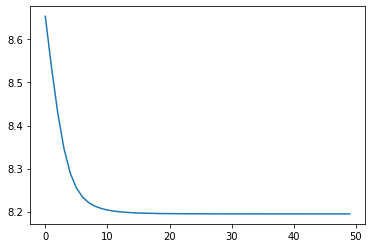

In [ ]:
#Loss evolution over epochs
plt.plot(range(n_epochs),losses)
plt.show()

In [ ]:
#Get 2 item recommendations for user with id 2
rec_sys.get_recommendation(2)

[195, 854]

In [ ]:
#Generate a new user not present in the rating matrix
user_vector = np.zeros(1000)

for i in range(5):
  user_vector[np.random.randint(0,1000)] = np.random.randint(1,5)

In [ ]:
#Get recommendation for the new user generated above
rec_sys.get_recommendation_new_user(user_vector,2)

[586, 744]

#Netflix

In [ ]:
#Download netflix test rating file
!gdown https://drive.google.com/uc?id=1aTq-QEQIqOOEn7MrDylAovQE0Ncms6lN

In [14]:
#retrive ratings from file
test = np.genfromtxt("/content/netflix_test.txt", delimiter = " ", dtype = "int32")[:,[0,1,3]]

In [ ]:
#Netflix data is a 2d matrix, each row is in the format [user_id, item_id , something we don't care about, ratings]
#We don't need index 2, which is why we only keep indexes 0, 1 and 3
test[:,[0,1,3]]

array([[     4,      1,      4],
       [    48,      1,      4],
       [    60,      1,      3],
       ...,
       [174372,  17770,      2],
       [206132,  17770,      3],
       [221852,  17770,      3]], dtype=int32)

In [34]:
#Create recommender system with latent dimension k = 100, learning rate of 0.0001 and regularization parameter of 1
rec_sys = recommender_system(100, 0.0001, 1)

In [35]:
#Load users with index <5000, items with index <5000
rec_sys.load_sparse_data(test, nb_rows_to_keep = 5000, nb_cols_to_keep = 5000, correct_shape = True)

In [37]:
#Train model above for 100 epochs
n_epochs = 100
losses = rec_sys.matrix_factorization(n_epochs)

RMSE after epoch is : 9.985555641554521
RMSE after epoch is : 9.982334697656125
RMSE after epoch is : 9.978623679682125
RMSE after epoch is : 9.976319709982878
RMSE after epoch is : 9.974931695641992
RMSE after epoch is : 9.97407419395256
RMSE after epoch is : 9.973528939361662
RMSE after epoch is : 9.973173180837144
RMSE after epoch is : 9.97293575595552
RMSE after epoch is : 9.972774080307435
RMSE after epoch is : 9.97266195975571
RMSE after epoch is : 9.972582898068959
RMSE after epoch is : 9.972526289615756
RMSE after epoch is : 9.97248518738643
RMSE after epoch is : 9.972454961533531
RMSE after epoch is : 9.972432475953369
RMSE after epoch is : 9.97241557344271
RMSE after epoch is : 9.972402748371383
RMSE after epoch is : 9.972392935312778
RMSE after epoch is : 9.972385370522511
RMSE after epoch is : 9.972379499857727
RMSE after epoch is : 9.972374916719586
RMSE after epoch is : 9.97237131966707
RMSE after epoch is : 9.972368483090612
RMSE after epoch is : 9.972366236667652
RMSE a

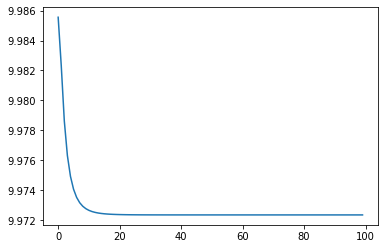

In [38]:
#Evolution of loss over epochs
plt.plot(range(100),losses)
plt.show()

In [39]:
#Save results of model
rec_sys.save_model("/content/reduced_netflix_model.pickle")

Done


In [40]:
#How to load model from weights
recommend_system_from_weights = recommender_system(100, 0.0001, 1)
recommend_system_from_weights.load_model("/content/reduced_netflix_model.pickle")

In [43]:
#generated new toy user, rating vector is of size 4997
new_user = generate_ratings(1,4997,10,30)[0]
new_user

array([0, 0, 0, ..., 0, 0, 0])

In [44]:
#get recommendations for user
recommend_system_from_weights.get_recommendation_new_user(new_user,5)

[1895, 1571, 1141, 4008, 3946]